# 🌀 Diffusion Models

Diffusion models can be considered hierarchicals VAE without a learned encoder

## 🎯 Motivation: Generating High-Quality Images

Diffusion models are a powerful class of **generative models** that can produce stunningly realistic images. They do this by learning how to **gradually denoise** random noise into data — in contrast to VAEs or GANs which directly output samples in one step.

---

## 🌫️ Forward Process: Diffusion

We define a **forward (noising) process** $q(x_{1:T} \mid x_0)$ that gradually adds Gaussian noise to a data sample $x_0$ over $T$ discrete time steps.

This process forms a **Markov chain** — each noisy sample $x_t$ depends **only on** the previous step $x_{t-1}$:

$$
q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \, x_{t-1}, \beta_t \mathbf{I})
$$

Where:

- $x_0$ is the original data sample
- $\beta_1, \dots, \beta_T$ is a fixed noise schedule
- As $t \to T$, $x_t$ becomes increasingly noisy and approaches pure Gaussian noise

> **About $\beta_t$**: Each $\beta_t$ controls how much **variance** is added at step $t$. Equivalently, we can define $\alpha_t = 1 - \beta_t$. Then, for each step:
> $$
> x_t = \sqrt{\alpha_t}\,x_{t-1} \;+\; \sqrt{1 - \alpha_t}\,\epsilon_t,
> $$
> where $\epsilon_t \sim \mathcal{N}(0,\mathbf{I})$. This $\beta$-based schedule allows direct control of the **amount of noise** injected each step.

The full joint distribution over the diffusion trajectory is:

$$
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

Because this is a **Markov process**, we don’t need to condition on the entire history — just the immediate predecessor.

---

## 🏎 Beta Schedules: Linear vs. Cosine

### Linear Beta Scheduling

- **Linear**: We simply pick $\beta_t$ to increase linearly from $\beta_{\text{start}}$ to $\beta_{\text{end}}$.  
- For example, $$\beta_t = \beta_{\text{start}} + t \cdot \frac{(\beta_{\text{end}} - \beta_{\text{start}})}{T-1}.$$
- **Pros**: Simple and easy to tune.
- **Cons**: Often adds too little noise in early steps and too much in later steps, sometimes causing less stable training or splotchy samples.

### Cosine Beta Scheduling

- **Cosine**: Proposed in *Improved DDPM* (Nichol & Dhariwal, 2021).
- Instead of defining $\beta_t$ directly, we define the cumulative product $\bar{\alpha}_t$ via a **cosine** function:
  $$
  \bar{\alpha}_t \;=\; \frac{\cos^2\!\bigl(\tfrac{(t/T + s)}{1 + s}\,\tfrac{\pi}{2}\bigr)}{\cos^2\!\bigl(\tfrac{s}{1 + s}\,\tfrac{\pi}{2}\bigr)},
  $$
  then recover $\beta_t$ from $\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}.$
- **Pros**: Smoother schedule; preserves more signal in early steps; often yields better sample quality.
- **Cons**: Slightly more complex to implement, though the code is still straightforward.

---

## 🔁 Reverse Process: Generative Modeling

To generate data, we define a **reverse-time Markov chain**:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t)
$$

Here:

- $p(x_T) = \mathcal{N}(0, \mathbf{I})$ is the starting point — pure Gaussian noise
- $p_\theta(x_{t-1} \mid x_t)$ is a learnable Gaussian distribution, parameterized by a neural network

Just like the forward process, this reverse chain is **Markovian**. Each step only depends on the current state $x_t$, not the entire history

This Markov structure simplifies the generative modeling process: we only need to learn how to take one step back in time, many times in a row.

Ideally, the learned reverse process $p_\theta(x_{t-1} \mid x_t)$ should match the true reverse conditionals $q(x_{t-1} \mid x_t, x_0)$ derived from the forward process.

---

## 📉 Variational Inference: ELBO Objective

Our ultimate goal is to model the **data distribution** $p_{\text{data}}(x_0)$ using a parameterized model $p_\theta(x_0)$. Ideally, we want to maximize:

$$
\log p_\theta(x_0)
$$

However, in a **latent variable model** like diffusion (or VAEs), $x_0$ is generated via **intermediate latent variables** — in this case, the noised versions $x_1, x_2, ..., x_T$.

So the marginal likelihood becomes:

$$
\log p_\theta(x_0) = \log \int p_\theta(x_0, x_1, ..., x_T) \, dx_{1:T}
= \log \int p_\theta(x_{0:T}) \, dx_{1:T}
$$

This integral is **intractable** because:

- $p_\theta(x_{t-1} \mid x_t)$ is parameterized by a neural network
- The latent space is high-dimensional (a trajectory over $T$ steps)

---

### 💡 Variational Trick: Importance Sampling

To deal with this, we apply **importance sampling**: introduce a known, tractable distribution $q(x_{1:T} \mid x_0)$ (the **forward diffusion process**) and rewrite the integral:

$$
\log p_\theta(x_0)
= \log \int \frac{q(x_{1:T} \mid x_0)}{q(x_{1:T} \mid x_0)} \, p_\theta(x_{0:T}) \, dx_{1:T}
= \log \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
$$

This is **exact** — we haven't approximated anything yet.

---

### ✅ Now Comes the Inequality: Jensen’s Inequality

The log of an expectation is **not equal to** the expectation of a log. In fact, by **Jensen’s inequality**, we have:

$$
\log \mathbb{E}_{q} \left[ f(x) \right] \geq \mathbb{E}_{q} \left[ \log f(x) \right]
$$

So applying this to our case:

$$
\log p_\theta(x_0)
= \log \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
\geq \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
$$

This **lower bound** is called the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p_\theta(x_{0:T}) - \log q(x_{1:T} \mid x_0)
\right]
$$

---

### 📌 Intuition

- We're approximating the true (intractable) marginal likelihood with a **lower bound** that we can **actually compute and optimize**.
- The closer $q(x_{1:T} \mid x_0)$ is to the true posterior $p_\theta(x_{1:T} \mid x_0)$, the **tighter** the bound.
- In VAEs, $q$ is learned. In diffusion, it’s **fixed** and designed — but still works because we structure it well (Gaussian forward steps).

---

## 🔁 Modeling the Joint Distributions

Let’s expand both terms:

### 🔹 Reverse (Generative) Process:

We define the joint generative distribution as:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t)
$$

Where:

- $p(x_T)$ is the standard Gaussian prior
- $p_\theta(x_{t-1} \mid x_t)$ is modeled as a Gaussian parameterized by a neural net

### 🔹 Forward (Variational) Process:

The forward process (used for inference) is fixed and Markovian:

$$
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

---

## 🧮 ELBO Breakdown

Plugging the expressions in:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p(x_T) + \sum_{t=1}^T \log p_\theta(x_{t-1} \mid x_t)
- \sum_{t=1}^T \log q(x_t \mid x_{t-1})
\right]
$$

Group terms by time step:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p(x_T) - \log q(x_1 \mid x_0)
+ \log p_\theta(x_0 \mid x_1)
+ \sum_{t=2}^T \left(
\log p_\theta(x_{t-1} \mid x_t) - \log q(x_t \mid x_{t-1})
\right)
\right]
$$

Rewriting in terms of KLs (using the closed-form for KL between Gaussians):

---

## 🔍 Interpretation of the ELBO Terms

### 🔹 1. Prior Matching at $t = T$

Encourages the terminal distribution $x_T$ to match the prior:

$$
D_{\text{KL}}(q(x_T \mid x_0) \, \| \, p(x_T))
$$

---

### 🔹 2. Reverse KL Terms for $t = 2, \dots, T$

Match the learned reverse distribution to the true posterior:

$$
\mathbb{E}_{q(x_{t}, x_{t-1} \mid x_0)} \left[
D_{\text{KL}} \left( q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t) \right)
\right]
$$

These KLs can be computed in closed form because all distributions are Gaussian.

---

### 🔹 3. Reconstruction Term at $t=1$

At the final step, the model attempts to reconstruct $x_0$ from the slightly noised $x_1$:

$$
- \mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]
$$

This is analogous to the VAE reconstruction loss.

---

## ✅ Final Variational Loss (Full DDPM Objective)

Bringing it all together:

$$
\mathcal{L}_{\text{VLB}} =
\underbrace{D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))}_{\text{Prior term}}
+ \sum_{t=2}^T
\underbrace{D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t))}_{\text{Reverse KLs}}
- \underbrace{\mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]}_{\text{Reconstruction}}
$$

This is the **original training objective** introduced in _DDPM (Ho et al., 2020)_ — and is a true variational lower bound on $\log p_\theta(x_0)$.

---

## ✂️ Simplifying the ELBO: From Variational Bound to Noise Prediction

In practice, diffusion models are trained using a **much simpler objective** than the full ELBO derived earlier. This section explains why that's valid and how it works.

---

### 🔁 Recall: The Full ELBO

The full ELBO from the DDPM objective is:

$$
\mathcal{L}_{\text{VLB}} =
D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))
+ \sum_{t=2}^T D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t))
- \mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]
$$

The **KL terms** at each timestep measure how well the learned reverse distribution $p_\theta(x_{t-1} \mid x_t)$ matches the true reverse posterior $q(x_{t-1} \mid x_t, x_0)$.

---

### 🧠 Insight: KL Between Gaussians Has a Closed Form

All distributions involved are Gaussian, so we can compute the KL divergence analytically.

Specifically, for each $t \geq 1$, the true posterior is:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}\left(x_{t-1}; \mu_q(x_t, x_0), \Sigma_q(t)\right)
$$

We approximate it with:

$$
p_\theta(x_{t-1} \mid x_t) = \mathcal{N}\left(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(t)\right)
$$

To minimize the KL divergence between these two Gaussians, we only need to match their **means** (since variances are fixed or learned separately). So:

> Training reduces to minimizing the squared error between the true posterior mean $\mu_q(x_t, x_0)$ and the predicted mean $\mu_\theta(x_t, t)$.

---

### 🧩 Expressing the True Mean $\mu_q$ in Terms of Noise $\epsilon$

From the **forward process**, we know that the noisy image at timestep $t$ can be written as a linear combination of the original image $x_0$ and Gaussian noise $\epsilon$:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon,
\quad \text{with } \epsilon \sim \mathcal{N}(0, \mathbf{I})
$$

This equation allows us to **sample $x_t$ from $x_0$**.

But what if we want to **recover $x_0$ from $x_t$**?

Assuming we *know* $\epsilon$, we can rearrange the equation:

$$
x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \, \epsilon \right)
$$

This means:  
> If we have $x_t$ and can estimate $\epsilon$, we can **reconstruct** $x_0$.

Now recall the **true reverse posterior**:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1}; \mu_q(x_t, x_0), \Sigma_q(t))
$$

We won't derive the exact form of $\mu_q$, but it turns out that it is a **linear combination of $x_t$ and $x_0$**:

$$
\mu_q(x_t, x_0) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon \right)
$$

> So again, we can write the **true mean of the reverse process** in terms of $(x_t, \epsilon)$.

If our model learns to **predict the noise $\epsilon$** from a given $(x_t, t)$, then we can **plug it in to compute $\mu_q$**, and thus define a Gaussian distribution from which we can sample $x_{t-1}$.

---

### 🧪 Final Simplified Objective: L2 Loss on Noise

Given that:

- We want to train a model $\epsilon_\theta(x_t, t)$ to predict the noise $\epsilon$ that was added to create $x_t$,
- And that $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon$,

We define the training loss as the **L2 distance** between the true noise $\epsilon$ and the predicted noise:

$$
\mathcal{L}_{\text{simple}}(x_0) =
\mathbb{E}_{t \sim \text{Uniform}(1, T),\, \epsilon \sim \mathcal{N}(0, I)} \left[
\left\| \epsilon - \epsilon_\theta(x_t, t) \right\|^2
\right]
$$

To compute this during training:

1. Sample $x_0$ from the dataset.
2. Sample a timestep $t$ uniformly at random.
3. Sample noise $\epsilon \sim \mathcal{N}(0, I)$.
4. Compute $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$.
5. Use the model to predict noise: $\hat{\epsilon} = \epsilon_\theta(x_t, t)$.
6. Minimize the squared error: $\|\epsilon - \hat{\epsilon}\|^2$.

This is equivalent to minimizing the KL divergence between $q(x_{t-1} \mid x_t, x_0)$ and $p_\theta(x_{t-1} \mid x_t)$.

---

### 🎨 How Noise Prediction is Used to Generate Images

Once the model is trained to predict noise, we can **generate images** starting from random noise. Here's how:

#### 1. Start from Gaussian noise:
$$
x_T \sim \mathcal{N}(0, \mathbf{I})
$$

#### 2. Run the reverse process:
For $t = T, T-1, \dots, 1$:

1. Predict noise: $\hat{\epsilon}_\theta = \epsilon_\theta(x_t, t)$
2. Estimate $x_0$:
   $$
   \hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \, \hat{\epsilon}_\theta \right)
   $$
3. Compute the mean of $p_\theta(x_{t-1} \mid x_t)$ using $\hat{x}_0$ (or directly use a pre-derived formula).
4. Sample:
   $$
   x_{t-1} \sim \mathcal{N}(\mu_\theta(x_t, \hat{\epsilon}_\theta), \Sigma_\theta(t))
   $$

Repeat until $x_0$, the final sample, is reached.

This $x_0$ is your **generated image**!

---

## ✅ Summary

- We use the forward process to generate training pairs $(x_t, \epsilon)$.
- The model learns to **predict $\epsilon$** from $(x_t, t)$.
- Once trained, we can **start from noise** and **denoise step-by-step** using the predicted $\epsilon$.
- The process is grounded in a **true probabilistic model** and the noise prediction is equivalent (up to constants) to maximizing the variational lower bound.

## References

- [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)
- [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672)

# 🚀 Extended Explanation of the Code

Below is a **supplement** to the earlier diffusion discussion. It explains the **components** in the provided code, such as **ShuffleNet-based UNet blocks**, **Time MLP** injection, and **training code specifics**. We connect these pieces to the standard diffusion framework — so you can see **how** they fit into the big picture.

---

## 1. **ShuffleNet-Based UNet Blocks**

We have a specialized **UNet** but with **ShuffleNet**-style depthwise convolution modules. Let’s see how it works:

1. **UNet**:  
   A typical UNet architecture has:  
   - **Encoders** (downsampling path)  
   - A **middle/bottleneck** (with large receptive field)  
   - **Decoders** (upsampling path)  
   - **Skip connections** from encoders to decoders  

2. **ShuffleNet**:  
   Usually, UNet blocks might be standard residual blocks or 3×3 convs. But here, we’re using **ShuffleNet** modules (`ResidualBottleneck`, `ResidualDownsample`) that do *grouped* or *depthwise* convolutions. This is more **parameter-efficient** and often faster on certain hardware.

3. **Channel Splitting and Shuffling**:  
   In a ShuffleNet block, a tensor is split into two channel groups, each processed by a separate “branch,” and then recombined. The layers do:
   - Depthwise conv (grouped by the number of channels)
   - $1\times 1$ conv to change channel count
   - A final “channel shuffle” operation to reduce correlation among channels

In code terms:
- `x1, x2 = x.chunk(2, dim=1)` splits the feature map into two halves.  
- Each half is convolved separately.  
- They’re then concatenated and reshuffled.

**Why do this for MNIST?**  
It’s overkill for $28\times 28$. But it’s a nice demonstration of a **scalable** approach that can be extended to bigger images if you want. It’s basically a **lightweight** version of typical residual blocks.

---

## 2. **TimeMLP**: Adding Timestep Embeddings at Each Stage

In diffusion, each UNet layer conditions on the **timestep** $t$. The code uses an `nn.Embedding` to convert $t$ into an embedding vector:
$$
t \;\xrightarrow[]{\text{Embedding}}\; \mathbf{e}_t \in \mathbb{R}^{d}
$$
and then **TimeMLP** further processes it:
$$
\mathbf{b}_t = \text{MLP}(\mathbf{e}_t) \in \mathbb{R}^{\text{channels}}
$$
We then do an **elementwise add** on the feature map, like:
$$
\mathbf{x} \;\leftarrow\; \mathbf{x} + \mathbf{b}_t\;.
$$
Thus each step “knows” how much noise is present, letting the network handle early/later steps differently.

In code:  

```python
x_short = x_short + t_emb # In TimeMLP's forward
x_short = activation(x_short) # In TimeMLP's forward
```

That’s basically a **FiLM**-style approach (feature-wise modulation). Because in diffusion, we often do scale-and-shift, or at least add a bias from the time embedding.

---

## 3. **EncoderBlock** / **DecoderBlock**: Putting It All Together

We can see lines like:

```python
# Inside EncoderBlock's forward method
x_short = self.conv0(x) 
if t is not None: # 't' here is the time embedding
    x_short = self.time_mlp(x_short, t) # inject time 
x_down = self.conv1(x_short) # downsample
```

**Encoder** steps:  
- 3× residual bottlenecks keep the spatial size.  
- Then do a `ResidualDownsample` to shrink feature maps by 2×.

**Decoder** steps:  
- Upsample by 2×.  
- Concat with skip connection from the encoder (`x_short`).  
- Another set of residual blocks, plus time injection.

Hence, it’s a **hierarchical** approach: each downsample doubles the channels, each upsample halves them.

---

## 4. **MNISTDiffusion** Class

This implements the entire diffusion pipeline. The main steps:

1. **Cosine Beta Schedule**:  
   We define betas $\beta_1,\dots,\beta_T$ with a **cosine** approach. Each $\alpha_t=1-\beta_t$. Then $\bar{\alpha}_t=\prod_{s=1}^t \alpha_s$.

2. **Forward**:  
   - The function `forward` picks random $t$, forms $x_t$ via:  
     $\displaystyle x_t = \sqrt{\bar{\alpha}_t}\,x + \sqrt{1-\bar{\alpha}_t}\,\text{noise}.$  
   - Feeds $x_t$ plus $t$ into the model to get $\hat{\epsilon}$.  
   - The training loss is $\|\hat{\epsilon}-\epsilon\|^2$.

3. **Sampling**:  
   - We start from $x_T \sim \mathcal{N}(0,I)$.  
   - For $t=T,T-1,\dots,1$, we do the reverse step:
     1. Predict noise $\hat{\epsilon}$.  
     2. Compute an estimate of $x_0$.  
     3. If $t>1$, we sample $x_{t-1}$ from a Gaussian with a mean derived from that estimate, plus variance $\sigma_t$.  

The code has functions:
- `q_sample`: forward noising
- `p_sample`: reverse denoising
- `p_sample_clipped`: same but clipping $x_0\in[-1,1]$  
This ensures we remain in a valid pixel range.

---

## 5. **Training with MSE**

**Training** is straightforward:
- Load MNIST, normalized to $[-1,1]$.  
- On each batch, sample a random step $t$, add noise to get $x_t$.  
- Predict noise, compute MSE vs. real noise.  
- **Update** parameters with an optimizer (Adam).  
- Every few epochs, we do `sample(...)` to generate images.

**Why MSE?**  
Because from the theoretical standpoint, matching $\hat{\epsilon}$ to $\epsilon$ is the same as matching $\mu_\theta$ to $\mu_q$ in the DDPM framework. In practice, MSE is simple and works well.

---

## 6. **Putting It All Together**

1. The code is a **DDPM** on MNIST, with:
   - A **ShuffleNet-based** UNet (lightweight, but enough capacity)
   - **Time embedding** via `nn.Embedding`, then added with the `TimeMLP` module
   - A **cosine** beta schedule for forward noising
   - **Clipping** of $x_0$ to keep pixel values in $[-1,1]$

2. **During training**:
   - The forward pass picks a random $t$, noised version $x_t$, and we do MSE with predicted $\hat{\epsilon}$.

3. **During sampling**:
   - We go from $x_T \sim \mathcal{N}(0,I)$ backward to $x_0$ using the learned reverse steps. Each iteration uses the model’s predicted noise to form a Gaussian “mean,” plus the scheduled variance. The final $x_0\in[-1,1]$ is mapped to $[0,1]$.

4. This code is a **fully functional** (and relatively short) **DDPM** on MNIST. Despite being “simple,” it includes advanced features: **cosine schedule, UNet, time conditioning**. That’s why it typically works well out of the box.

---

## 🎉 **Conclusion**

- **The entire pipeline** is a standard **DDPM** with typical improvements: **cosine betas**, and a **residual UNet** with **time embedding**.  
- The math is the same as the original **DDPM** framework, just with a specialized architecture and schedule.  
- This is why it consistently trains successfully on MNIST, whereas naive approaches can sometimes fail to converge or produce “blank” images.

You now have a **complete** mental map of the code’s moving parts — from the **diffusion objective** to the **ShuffleNet blocks**.


In [1]:
# Adapted from https://github.com/bot66/MNISTDiffusion

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


##################################################
# 1) ShuffleNet-based blocks for the UNet
##################################################
class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super().__init__()
        self.groups = groups

    def forward(self, x):
        N, C, H, W = x.shape
        assert C % self.groups == 0
        x = x.view(N, self.groups, C // self.groups, H, W)
        x = x.transpose(1, 2).contiguous()
        x = x.view(N, C, H, W)
        return x


class ConvBnSiLu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.module(x)


class ResidualBottleneck(nn.Module):
    """
    ShuffleNetV2 basic unit
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(
                in_channels // 2, in_channels // 2, 3, 1, 1, groups=in_channels // 2
            ),
            nn.BatchNorm2d(in_channels // 2),
            ConvBnSiLu(in_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.branch2 = nn.Sequential(
            ConvBnSiLu(in_channels // 2, in_channels // 2, 1, 1, 0),
            nn.Conv2d(
                in_channels // 2, in_channels // 2, 3, 1, 1, groups=in_channels // 2
            ),
            nn.BatchNorm2d(in_channels // 2),
            ConvBnSiLu(in_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.channel_shuffle = ChannelShuffle(2)

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        out = torch.cat([self.branch1(x1), self.branch2(x2)], dim=1)
        return self.channel_shuffle(out)


class ResidualDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, 2, 1, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            ConvBnSiLu(in_channels, out_channels // 2, 1, 1, 0),
        )
        self.branch2 = nn.Sequential(
            ConvBnSiLu(in_channels, out_channels // 2, 1, 1, 0),
            nn.Conv2d(
                out_channels // 2, out_channels // 2, 3, 2, 1, groups=out_channels // 2
            ),
            nn.BatchNorm2d(out_channels // 2),
            ConvBnSiLu(out_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.channel_shuffle = ChannelShuffle(2)

    def forward(self, x):
        out = torch.cat([self.branch1(x), self.branch2(x)], dim=1)
        return self.channel_shuffle(out)


class TimeMLP(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim),
        )
        self.act = nn.SiLU()

    def forward(self, x, t):
        t_emb = self.mlp(t).unsqueeze(-1).unsqueeze(-1)
        x = x + t_emb
        return self.act(x)


class EncoderBlock(nn.Module):
    """
    Nx ResidualBottleneck => channel transform => TimeMLP => Downsample
    """

    def __init__(self, in_channels, out_channels, time_dim, num_res_blocks=3):
        super().__init__()
        self.conv0 = nn.Sequential(
            *[ResidualBottleneck(in_channels, in_channels) for _ in range(num_res_blocks)],
            ResidualBottleneck(in_channels, out_channels // 2),
        )
        self.time_mlp = TimeMLP(
            embedding_dim=time_dim, hidden_dim=out_channels, out_dim=out_channels // 2
        )
        self.conv1 = ResidualDownsample(out_channels // 2, out_channels)

    def forward(self, x, t=None):
        x_short = self.conv0(x)
        if t is not None:
            x_short = self.time_mlp(x_short, t)
        x_down = self.conv1(x_short)
        return x_down, x_short


class DecoderBlock(nn.Module):
    """
    Upsample => cat skip => Nx ResidualBottleneck => channel transform => TimeMLP => final bottleneck
    """

    def __init__(self, in_channels, out_channels, time_dim, num_res_blocks=3):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv0 = nn.Sequential(
            *[ResidualBottleneck(in_channels, in_channels) for _ in range(num_res_blocks)],
            ResidualBottleneck(in_channels, in_channels // 2),
        )
        self.time_mlp = TimeMLP(
            time_dim, hidden_dim=in_channels, out_dim=in_channels // 2
        )
        self.conv1 = ResidualBottleneck(in_channels // 2, out_channels // 2)

    def forward(self, x, x_short, t=None):
        x = self.up(x)
        x = torch.cat([x, x_short], dim=1)
        x = self.conv0(x)
        if t is not None:
            x = self.time_mlp(x, t)
        x = self.conv1(x)
        return x


class Unet(nn.Module):
    """
    ShuffleNet-like UNet for 28x28.
    """

    def __init__(
        self,
        timesteps,
        time_embedding_dim,
        in_channels=1,
        out_channels=1,
        base_dim=64,
        dim_mults=[2, 4],
        num_res_blocks_encoder=3,
        num_res_blocks_decoder=3,
        num_res_blocks_mid=2,
    ):
        super().__init__()
        self.init_conv = ConvBnSiLu(in_channels, base_dim, 3, 1, 1)
        self.time_emb = nn.Embedding(timesteps, time_embedding_dim)

        # build channels
        self.channels = []
        prev_c = base_dim
        for m in dim_mults:
            c_out = base_dim * m
            self.channels.append((prev_c, c_out))
            prev_c = c_out

        # enc blocks
        self.enc_blocks = nn.ModuleList(
            [
                EncoderBlock(c_in, c_out, time_embedding_dim, num_res_blocks=num_res_blocks_encoder)
                for (c_in, c_out) in self.channels
            ]
        )

        # mid
        mid_channels = self.channels[-1][1]
        self.mid = nn.Sequential(
            *[ResidualBottleneck(mid_channels, mid_channels) for _ in range(num_res_blocks_mid)],
            ResidualBottleneck(mid_channels, mid_channels // 2),
        )

        # dec blocks (reverse)
        rev = list(reversed(self.channels))
        self.dec_blocks = nn.ModuleList(
            [DecoderBlock(c_out, c_in, time_embedding_dim, num_res_blocks=num_res_blocks_decoder) for (c_in, c_out) in rev]
        )

        # final conv
        last_in = rev[-1][0] // 2
        self.final_conv = nn.Conv2d(last_in, out_channels, 1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)

        # init
        x = self.init_conv(x)

        # encode
        skips = []
        for enc_block in self.enc_blocks:
            x, x_short = enc_block(x, t_emb)
            skips.append(x_short)

        # mid
        x = self.mid(x)

        # decode
        skips.reverse()
        for dec_block, sk in zip(self.dec_blocks, skips):
            x = dec_block(x, sk, t_emb)

        return self.final_conv(x)


##################################################
# 2) MNISTDiffusion with Cosine Beta Schedule
##################################################
class MNISTDiffusion(nn.Module):
    def __init__(
        self,
        image_size=28,
        in_channels=1,
        time_embedding_dim=256,
        timesteps=1000,
        base_dim=64,
        dim_mults=[2, 4],
        num_res_blocks_encoder=3,
        num_res_blocks_decoder=3,
        num_res_blocks_mid=2,
    ):
        super().__init__()
        self.timesteps = timesteps
        self.in_channels = in_channels
        self.image_size = image_size

        betas = self._cosine_variance_schedule(timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )

        self.model = Unet(
            timesteps=timesteps,
            time_embedding_dim=time_embedding_dim,
            in_channels=in_channels,
            out_channels=in_channels,
            base_dim=base_dim,
            dim_mults=dim_mults,
            num_res_blocks_encoder=num_res_blocks_encoder,
            num_res_blocks_decoder=num_res_blocks_decoder,
            num_res_blocks_mid=num_res_blocks_mid,
        )

    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = (
            torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5)
            ** 2
        )
        betas = torch.clip(1.0 - f_t[1:] / f_t[:-1], 0.0, 0.999)
        return betas

    def forward(self, x, noise):
        """
        x: [B, in_ch, H, W]
        noise: same shape
        random t -> x_t -> predict noise
        """
        B = x.shape[0]
        t = torch.randint(0, self.timesteps, (B,), device=x.device)
        x_t = self.q_sample(x, t, noise)
        pred_noise = self.model(x_t, t)
        return pred_noise

    @torch.no_grad()
    def sample(self, n_samples=16, clipped=True, device="cuda"):
        """
        Reverse sampling
        """
        x = torch.randn(
            n_samples, self.in_channels, self.image_size, self.image_size, device=device
        )
        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)
            noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)

            if clipped:
                x = self.p_sample_clipped(x, t, noise)
            else:
                x = self.p_sample(x, t, noise)

        x = (x + 1.0) / 2.0  # [-1,1]->[0,1]
        return x

    def q_sample(self, x0, t, noise):
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_t * noise

    @torch.no_grad()
    def p_sample(self, x_t, t, noise):
        pred = self.model(x_t, t)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_cum_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - ((1.0 - alpha_t) / sqrt_one_minus_cum_t) * pred
        )
        if t.min() > 0:
            alpha_cum_prev = self.alphas_cumprod[(t - 1).clamp_min(0)].view(-1, 1, 1, 1)
            std = torch.sqrt(beta_t * (1.0 - alpha_cum_prev) / (1.0 - alpha_cum_t))
        else:
            std = 0.0
        return mean + std * noise

    @torch.no_grad()
    def p_sample_clipped(self, x_t, t, noise):
        pred = self.model(x_t, t)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)

        # x_0 pred
        x_0_pred = (1.0 / torch.sqrt(alpha_cum_t)) * x_t - torch.sqrt(
            1.0 / alpha_cum_t - 1.0
        ) * pred
        x_0_pred.clamp_(-1.0, 1.0)

        if t.min() > 0:
            alpha_cum_prev = self.alphas_cumprod[(t - 1).clamp_min(0)].view(-1, 1, 1, 1)
            mean = (
                beta_t * torch.sqrt(alpha_cum_prev) / (1.0 - alpha_cum_t)
            ) * x_0_pred + (
                (1.0 - alpha_cum_prev) * torch.sqrt(alpha_t) / (1.0 - alpha_cum_t)
            ) * x_t
            std = torch.sqrt(beta_t * (1.0 - alpha_cum_prev) / (1.0 - alpha_cum_t))
        else:
            mean = (beta_t / (1.0 - alpha_cum_t)) * x_0_pred
            std = 0.0
        return mean + std * noise


##################################################
# 3) Simplified Training Loop (Jupyter-friendly)
##################################################
def train_mnist_diffusion(
    lr=1e-3,
    batch_size=128,
    epochs=10,
    timesteps=500,
    model_base_dim=32,
    dim_mults=[2, 4],
    num_res_blocks_encoder=3,
    num_res_blocks_decoder=3,
    num_res_blocks_mid=2,
    device="cuda",
    log_freq=50,
    show_every=2,
    n_samples=16,
):
    """
    Trains a ShuffleNet-based UNet with a Cosine Beta DDPM on MNIST
    and displays generated samples in the notebook every `show_every` epochs.
    """
    # 1) DataLoader
    transform = transforms.Compose(
        [
            transforms.Resize(28),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),  # [0,1]->[-1,1]
        ]
    )
    train_data = MNIST("./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # 2) Model
    ddpm = MNISTDiffusion(
        image_size=28,
        in_channels=1,
        time_embedding_dim=256,
        timesteps=timesteps,
        base_dim=model_base_dim,
        dim_mults=dim_mults,
        num_res_blocks_encoder=num_res_blocks_encoder,
        num_res_blocks_decoder=num_res_blocks_decoder,
        num_res_blocks_mid=num_res_blocks_mid,
    ).to(device)

    # Print number of parameters
    total_params = sum(p.numel() for p in ddpm.model.parameters() if p.requires_grad)
    print(f"UNet model has {total_params:,} trainable parameters.")

    # 3) Optim / Loss
    optimizer = torch.optim.Adam(ddpm.parameters(), lr=lr)
    mse = nn.MSELoss()

    global_step = 0
    for epoch in tqdm(range(epochs), desc="Total Epochs"):
        ddpm.train()
        total_loss = 0
        batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for step, (images, _) in batch_pbar:
            images = images.to(device)
            noise = torch.randn_like(images)

            pred_noise = ddpm(images, noise)  # random t inside
            loss = mse(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            global_step += 1
            if step % log_freq == 0:
                batch_pbar.set_postfix_str(f"Loss={loss.item():.4f}")
                # Optional: keep print if you prefer explicit logs alongside tqdm
                # print(
                #     f"Epoch[{epoch+1}/{epochs}], Step[{step}/{len(train_loader)}], Loss={loss.item():.4f}"
                # )

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} done. Avg Loss: {avg_loss:.4f}")

        # show samples in the notebook every `show_every` epochs
        if (epoch + 1) % show_every == 0 or epoch == epochs - 1:
            ddpm.eval()
            with torch.no_grad():
                samples = ddpm.sample(n_samples=n_samples, clipped=True, device=device)
            samples = samples.cpu()

            # Display in the notebook
            grid = make_grid(
                samples,
                nrow=int(math.sqrt(n_samples)),
                normalize=True,
                value_range=(0, 1),
            )
            plt.figure(figsize=(4, 4))
            plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
            plt.title(f"Samples at epoch {epoch+1}")
            plt.axis("off")
            plt.show()

    print("Training complete!")


/home/tk/.virtualenvs/dev-python3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UNet model has 132,809 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:11<19:29, 11.81s/it]

Epoch 1 done. Avg Loss: 0.4029


Total Epochs:   2%|▏         | 2/100 [00:23<18:52, 11.55s/it]

Epoch 2 done. Avg Loss: 0.0989


Total Epochs:   3%|▎         | 3/100 [00:34<18:33, 11.48s/it]

Epoch 3 done. Avg Loss: 0.0735


Total Epochs:   4%|▍         | 4/100 [00:46<18:24, 11.50s/it]

Epoch 4 done. Avg Loss: 0.0640


Total Epochs:   5%|▌         | 5/100 [00:57<18:10, 11.47s/it]

Epoch 5 done. Avg Loss: 0.0594


Total Epochs:   6%|▌         | 6/100 [01:08<17:56, 11.45s/it]

Epoch 6 done. Avg Loss: 0.0562


Total Epochs:   7%|▋         | 7/100 [01:20<17:43, 11.43s/it]

Epoch 7 done. Avg Loss: 0.0540


Total Epochs:   8%|▊         | 8/100 [01:31<17:33, 11.45s/it]

Epoch 8 done. Avg Loss: 0.0528


Total Epochs:   9%|▉         | 9/100 [01:43<17:22, 11.46s/it]

Epoch 9 done. Avg Loss: 0.0516


Epoch 10 done. Avg Loss: 0.0507


Sampling: 100%|██████████| 200/200 [00:00<00:00, 276.08it/s]


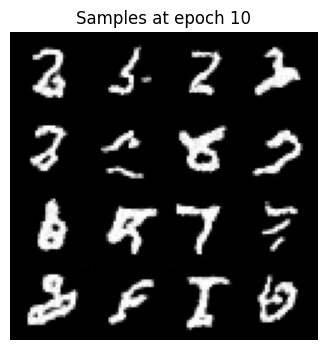

Total Epochs:  11%|█         | 11/100 [02:07<17:18, 11.67s/it]

Epoch 11 done. Avg Loss: 0.0503


Total Epochs:  12%|█▏        | 12/100 [02:18<17:05, 11.65s/it]

Epoch 12 done. Avg Loss: 0.0492


Total Epochs:  13%|█▎        | 13/100 [02:29<16:35, 11.44s/it]

Epoch 13 done. Avg Loss: 0.0488


Total Epochs:  14%|█▍        | 14/100 [02:40<16:08, 11.26s/it]

Epoch 14 done. Avg Loss: 0.0482


Total Epochs:  15%|█▌        | 15/100 [02:51<15:45, 11.12s/it]

Epoch 15 done. Avg Loss: 0.0480


Total Epochs:  16%|█▌        | 16/100 [03:02<15:28, 11.06s/it]

Epoch 16 done. Avg Loss: 0.0477


Total Epochs:  17%|█▋        | 17/100 [03:13<15:12, 11.00s/it]

Epoch 17 done. Avg Loss: 0.0467


Total Epochs:  18%|█▊        | 18/100 [03:23<14:57, 10.94s/it]

Epoch 18 done. Avg Loss: 0.0475


Total Epochs:  19%|█▉        | 19/100 [03:35<14:58, 11.09s/it]

Epoch 19 done. Avg Loss: 0.0469


Epoch 20 done. Avg Loss: 0.0465


Sampling: 100%|██████████| 200/200 [00:00<00:00, 285.14it/s]


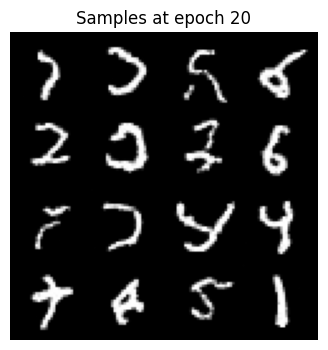

Total Epochs:  21%|██        | 21/100 [03:59<15:07, 11.48s/it]

Epoch 21 done. Avg Loss: 0.0461


Total Epochs:  22%|██▏       | 22/100 [04:10<14:53, 11.46s/it]

Epoch 22 done. Avg Loss: 0.0462


Total Epochs:  23%|██▎       | 23/100 [04:22<14:42, 11.46s/it]

Epoch 23 done. Avg Loss: 0.0453


Total Epochs:  24%|██▍       | 24/100 [04:33<14:32, 11.48s/it]

Epoch 24 done. Avg Loss: 0.0451


Total Epochs:  25%|██▌       | 25/100 [04:45<14:21, 11.49s/it]

Epoch 25 done. Avg Loss: 0.0451


Total Epochs:  26%|██▌       | 26/100 [04:56<14:11, 11.51s/it]

Epoch 26 done. Avg Loss: 0.0453


Total Epochs:  27%|██▋       | 27/100 [05:08<14:01, 11.52s/it]

Epoch 27 done. Avg Loss: 0.0448


Total Epochs:  28%|██▊       | 28/100 [05:19<13:49, 11.52s/it]

Epoch 28 done. Avg Loss: 0.0448


Total Epochs:  29%|██▉       | 29/100 [05:31<13:38, 11.53s/it]

Epoch 29 done. Avg Loss: 0.0444


Epoch 30 done. Avg Loss: 0.0443


Sampling: 100%|██████████| 200/200 [00:00<00:00, 282.31it/s]


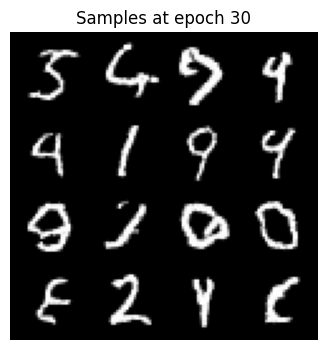

Total Epochs:  31%|███       | 31/100 [05:55<13:29, 11.74s/it]

Epoch 31 done. Avg Loss: 0.0443


Total Epochs:  32%|███▏      | 32/100 [06:06<13:17, 11.72s/it]

Epoch 32 done. Avg Loss: 0.0442


Total Epochs:  33%|███▎      | 33/100 [06:18<13:03, 11.69s/it]

Epoch 33 done. Avg Loss: 0.0439


Total Epochs:  34%|███▍      | 34/100 [06:30<12:51, 11.69s/it]

Epoch 34 done. Avg Loss: 0.0440


Total Epochs:  35%|███▌      | 35/100 [06:41<12:37, 11.65s/it]

Epoch 35 done. Avg Loss: 0.0436


Total Epochs:  36%|███▌      | 36/100 [06:53<12:24, 11.63s/it]

Epoch 36 done. Avg Loss: 0.0438


Total Epochs:  37%|███▋      | 37/100 [07:05<12:13, 11.64s/it]

Epoch 37 done. Avg Loss: 0.0436


Total Epochs:  38%|███▊      | 38/100 [07:16<11:58, 11.59s/it]

Epoch 38 done. Avg Loss: 0.0436


Total Epochs:  39%|███▉      | 39/100 [07:28<11:46, 11.59s/it]

Epoch 39 done. Avg Loss: 0.0433


Epoch 40 done. Avg Loss: 0.0430


Sampling: 100%|██████████| 200/200 [00:00<00:00, 299.02it/s]


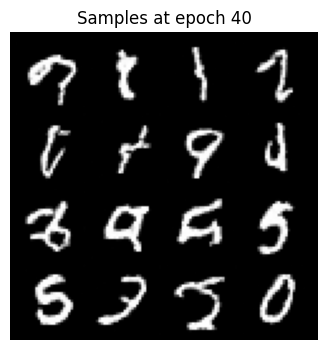

Total Epochs:  41%|████      | 41/100 [07:51<11:29, 11.69s/it]

Epoch 41 done. Avg Loss: 0.0433


Total Epochs:  42%|████▏     | 42/100 [08:03<11:15, 11.65s/it]

Epoch 42 done. Avg Loss: 0.0433


Total Epochs:  43%|████▎     | 43/100 [08:15<11:04, 11.65s/it]

Epoch 43 done. Avg Loss: 0.0428


Total Epochs:  44%|████▍     | 44/100 [08:26<10:49, 11.60s/it]

Epoch 44 done. Avg Loss: 0.0427


Total Epochs:  45%|████▌     | 45/100 [08:38<10:37, 11.59s/it]

Epoch 45 done. Avg Loss: 0.0426


Total Epochs:  46%|████▌     | 46/100 [08:49<10:24, 11.57s/it]

Epoch 46 done. Avg Loss: 0.0424


Total Epochs:  47%|████▋     | 47/100 [09:01<10:13, 11.58s/it]

Epoch 47 done. Avg Loss: 0.0426


Total Epochs:  48%|████▊     | 48/100 [09:12<10:01, 11.57s/it]

Epoch 48 done. Avg Loss: 0.0424


Total Epochs:  49%|████▉     | 49/100 [09:24<09:49, 11.56s/it]

Epoch 49 done. Avg Loss: 0.0426


Epoch 50 done. Avg Loss: 0.0424


Sampling: 100%|██████████| 200/200 [00:00<00:00, 296.22it/s]


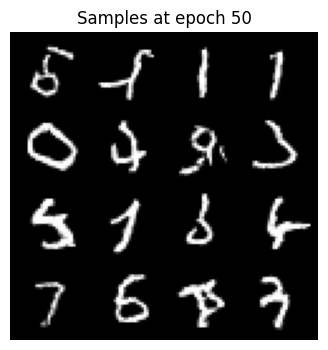

Total Epochs:  51%|█████     | 51/100 [09:48<09:34, 11.72s/it]

Epoch 51 done. Avg Loss: 0.0425


Total Epochs:  52%|█████▏    | 52/100 [09:59<09:20, 11.68s/it]

Epoch 52 done. Avg Loss: 0.0425


Total Epochs:  53%|█████▎    | 53/100 [10:11<09:07, 11.64s/it]

Epoch 53 done. Avg Loss: 0.0423


Total Epochs:  54%|█████▍    | 54/100 [10:22<08:55, 11.64s/it]

Epoch 54 done. Avg Loss: 0.0420


Total Epochs:  55%|█████▌    | 55/100 [10:34<08:40, 11.57s/it]

Epoch 55 done. Avg Loss: 0.0422


Total Epochs:  56%|█████▌    | 56/100 [10:45<08:29, 11.58s/it]

Epoch 56 done. Avg Loss: 0.0418


Total Epochs:  57%|█████▋    | 57/100 [10:57<08:16, 11.55s/it]

Epoch 57 done. Avg Loss: 0.0417


Total Epochs:  58%|█████▊    | 58/100 [11:08<08:04, 11.52s/it]

Epoch 58 done. Avg Loss: 0.0419


Total Epochs:  59%|█████▉    | 59/100 [11:20<07:53, 11.56s/it]

Epoch 59 done. Avg Loss: 0.0419


Epoch 60 done. Avg Loss: 0.0417


Sampling: 100%|██████████| 200/200 [00:00<00:00, 291.78it/s]


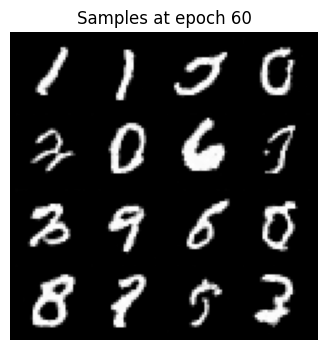

Total Epochs:  61%|██████    | 61/100 [11:44<07:37, 11.73s/it]

Epoch 61 done. Avg Loss: 0.0420


Total Epochs:  62%|██████▏   | 62/100 [11:55<07:23, 11.66s/it]

Epoch 62 done. Avg Loss: 0.0415


Total Epochs:  63%|██████▎   | 63/100 [12:12<08:02, 13.03s/it]

Epoch 63 done. Avg Loss: 0.0417


Total Epochs:  64%|██████▍   | 64/100 [12:26<07:58, 13.30s/it]

Epoch 64 done. Avg Loss: 0.0415


Total Epochs:  65%|██████▌   | 65/100 [12:41<08:07, 13.92s/it]

Epoch 65 done. Avg Loss: 0.0418


Total Epochs:  66%|██████▌   | 66/100 [13:01<08:50, 15.62s/it]

Epoch 66 done. Avg Loss: 0.0414


Total Epochs:  67%|██████▋   | 67/100 [13:20<09:14, 16.81s/it]

Epoch 67 done. Avg Loss: 0.0413


Total Epochs:  68%|██████▊   | 68/100 [13:40<09:25, 17.66s/it]

Epoch 68 done. Avg Loss: 0.0416


Total Epochs:  69%|██████▉   | 69/100 [14:00<09:26, 18.29s/it]

Epoch 69 done. Avg Loss: 0.0409


Epoch 70 done. Avg Loss: 0.0416


Sampling: 100%|██████████| 200/200 [00:00<00:00, 255.32it/s]


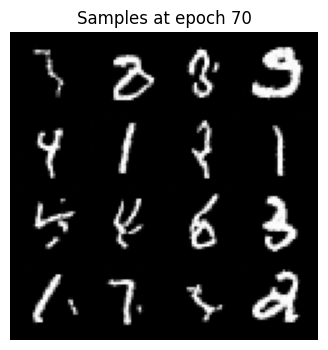

Total Epochs:  71%|███████   | 71/100 [14:40<09:15, 19.14s/it]

Epoch 71 done. Avg Loss: 0.0413


Total Epochs:  72%|███████▏  | 72/100 [14:59<08:59, 19.25s/it]

Epoch 72 done. Avg Loss: 0.0412


Total Epochs:  73%|███████▎  | 73/100 [15:19<08:43, 19.41s/it]

Epoch 73 done. Avg Loss: 0.0411


Total Epochs:  74%|███████▍  | 74/100 [15:39<08:26, 19.49s/it]

Epoch 74 done. Avg Loss: 0.0414


Total Epochs:  75%|███████▌  | 75/100 [15:58<08:07, 19.52s/it]

Epoch 75 done. Avg Loss: 0.0411


Total Epochs:  76%|███████▌  | 76/100 [16:11<07:02, 17.59s/it]

Epoch 76 done. Avg Loss: 0.0410


Total Epochs:  77%|███████▋  | 77/100 [16:24<06:12, 16.18s/it]

Epoch 77 done. Avg Loss: 0.0411


Total Epochs:  78%|███████▊  | 78/100 [16:44<06:19, 17.27s/it]

Epoch 78 done. Avg Loss: 0.0409


Total Epochs:  79%|███████▉  | 79/100 [17:04<06:17, 17.98s/it]

Epoch 79 done. Avg Loss: 0.0412


Epoch 80 done. Avg Loss: 0.0410


Sampling: 100%|██████████| 200/200 [00:00<00:00, 233.53it/s]


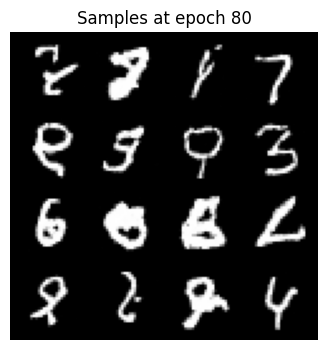

Total Epochs:  81%|████████  | 81/100 [17:44<06:00, 18.99s/it]

Epoch 81 done. Avg Loss: 0.0409


Total Epochs:  82%|████████▏ | 82/100 [18:03<05:45, 19.21s/it]

Epoch 82 done. Avg Loss: 0.0409


Total Epochs:  83%|████████▎ | 83/100 [18:23<05:27, 19.24s/it]

Epoch 83 done. Avg Loss: 0.0407


Total Epochs:  84%|████████▍ | 84/100 [18:42<05:09, 19.35s/it]

Epoch 84 done. Avg Loss: 0.0410


Total Epochs:  85%|████████▌ | 85/100 [19:02<04:51, 19.41s/it]

Epoch 85 done. Avg Loss: 0.0408


Total Epochs:  86%|████████▌ | 86/100 [19:21<04:31, 19.43s/it]

Epoch 86 done. Avg Loss: 0.0411


Total Epochs:  87%|████████▋ | 87/100 [19:41<04:13, 19.49s/it]

Epoch 87 done. Avg Loss: 0.0409


Total Epochs:  88%|████████▊ | 88/100 [20:00<03:53, 19.49s/it]

Epoch 88 done. Avg Loss: 0.0408


Total Epochs:  89%|████████▉ | 89/100 [20:20<03:34, 19.52s/it]

Epoch 89 done. Avg Loss: 0.0408


Epoch 90 done. Avg Loss: 0.0406


Sampling: 100%|██████████| 200/200 [00:00<00:00, 212.77it/s]


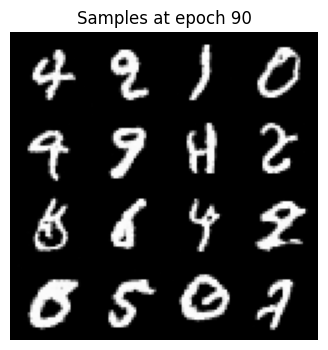

Total Epochs:  91%|█████████ | 91/100 [20:57<02:50, 18.89s/it]

Epoch 91 done. Avg Loss: 0.0408


Total Epochs:  92%|█████████▏| 92/100 [21:09<02:13, 16.73s/it]

Epoch 92 done. Avg Loss: 0.0407


Total Epochs:  93%|█████████▎| 93/100 [21:21<01:46, 15.19s/it]

Epoch 93 done. Avg Loss: 0.0411


Total Epochs:  94%|█████████▍| 94/100 [21:32<01:24, 14.08s/it]

Epoch 94 done. Avg Loss: 0.0406


Total Epochs:  95%|█████████▌| 95/100 [21:44<01:06, 13.33s/it]

Epoch 95 done. Avg Loss: 0.0405


Total Epochs:  96%|█████████▌| 96/100 [21:55<00:51, 12.77s/it]

Epoch 96 done. Avg Loss: 0.0406


Total Epochs:  97%|█████████▋| 97/100 [22:07<00:37, 12.39s/it]

Epoch 97 done. Avg Loss: 0.0404


Total Epochs:  98%|█████████▊| 98/100 [22:18<00:24, 12.16s/it]

Epoch 98 done. Avg Loss: 0.0403


Total Epochs:  99%|█████████▉| 99/100 [22:30<00:11, 11.94s/it]

Epoch 99 done. Avg Loss: 0.0404


Epoch 100 done. Avg Loss: 0.0408


Sampling: 100%|██████████| 200/200 [00:00<00:00, 280.79it/s]


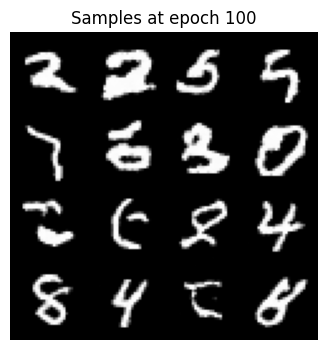

Total Epochs: 100%|██████████| 100/100 [22:42<00:00, 13.63s/it]

Training complete!


In [2]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=256,  
    epochs=100,      
    timesteps=200,  
    model_base_dim=16, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=1, 
    num_res_blocks_decoder=1, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

UNet model has 335,649 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:28<47:29, 28.79s/it]

Epoch 1 done. Avg Loss: 0.3130


Total Epochs:   2%|▏         | 2/100 [00:57<46:38, 28.56s/it]

Epoch 2 done. Avg Loss: 0.0944


Total Epochs:   3%|▎         | 3/100 [01:26<46:23, 28.70s/it]

Epoch 3 done. Avg Loss: 0.0687


Total Epochs:   4%|▍         | 4/100 [01:54<45:51, 28.66s/it]

Epoch 4 done. Avg Loss: 0.0602


Total Epochs:   5%|▌         | 5/100 [02:24<45:54, 28.99s/it]

Epoch 5 done. Avg Loss: 0.0552


Total Epochs:   6%|▌         | 6/100 [03:10<54:50, 35.00s/it]

Epoch 6 done. Avg Loss: 0.0526


Total Epochs:   7%|▋         | 7/100 [04:03<1:03:18, 40.84s/it]

Epoch 7 done. Avg Loss: 0.0506


Total Epochs:   8%|▊         | 8/100 [04:57<1:08:54, 44.94s/it]

Epoch 8 done. Avg Loss: 0.0488


Total Epochs:   9%|▉         | 9/100 [05:51<1:12:18, 47.68s/it]

Epoch 9 done. Avg Loss: 0.0480


Epoch 10 done. Avg Loss: 0.0471


Sampling: 100%|██████████| 400/400 [00:01<00:00, 205.56it/s]


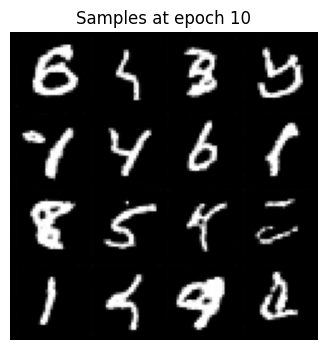

Total Epochs:  11%|█         | 11/100 [07:38<1:15:23, 50.83s/it]

Epoch 11 done. Avg Loss: 0.0461


Total Epochs:  12%|█▏        | 12/100 [08:31<1:15:27, 51.45s/it]

Epoch 12 done. Avg Loss: 0.0458


Total Epochs:  13%|█▎        | 13/100 [09:24<1:15:09, 51.83s/it]

Epoch 13 done. Avg Loss: 0.0453


Total Epochs:  14%|█▍        | 14/100 [10:17<1:14:44, 52.14s/it]

Epoch 14 done. Avg Loss: 0.0446


Total Epochs:  15%|█▌        | 15/100 [11:10<1:14:15, 52.41s/it]

Epoch 15 done. Avg Loss: 0.0438


Total Epochs:  16%|█▌        | 16/100 [12:03<1:13:38, 52.60s/it]

Epoch 16 done. Avg Loss: 0.0438


Total Epochs:  17%|█▋        | 17/100 [12:42<1:06:54, 48.37s/it]

Epoch 17 done. Avg Loss: 0.0435


Total Epochs:  18%|█▊        | 18/100 [13:09<57:43, 42.24s/it]  

Epoch 18 done. Avg Loss: 0.0430


Total Epochs:  19%|█▉        | 19/100 [13:37<51:13, 37.94s/it]

Epoch 19 done. Avg Loss: 0.0434


Epoch 20 done. Avg Loss: 0.0425


Sampling: 100%|██████████| 400/400 [00:01<00:00, 234.15it/s]


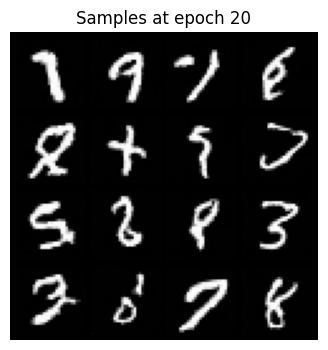

Total Epochs:  21%|██        | 21/100 [15:01<53:09, 40.37s/it]

Epoch 21 done. Avg Loss: 0.0424


Total Epochs:  22%|██▏       | 22/100 [15:55<57:47, 44.46s/it]

Epoch 22 done. Avg Loss: 0.0424


Total Epochs:  23%|██▎       | 23/100 [16:49<1:00:44, 47.33s/it]

Epoch 23 done. Avg Loss: 0.0422


Total Epochs:  24%|██▍       | 24/100 [17:43<1:02:28, 49.32s/it]

Epoch 24 done. Avg Loss: 0.0416


Total Epochs:  25%|██▌       | 25/100 [18:37<1:03:18, 50.65s/it]

Epoch 25 done. Avg Loss: 0.0416


Total Epochs:  26%|██▌       | 26/100 [19:31<1:03:44, 51.68s/it]

Epoch 26 done. Avg Loss: 0.0415


Total Epochs:  27%|██▋       | 27/100 [20:25<1:03:51, 52.48s/it]

Epoch 27 done. Avg Loss: 0.0412


Total Epochs:  28%|██▊       | 28/100 [21:19<1:03:35, 52.99s/it]

Epoch 28 done. Avg Loss: 0.0411


Total Epochs:  29%|██▉       | 29/100 [22:14<1:03:18, 53.50s/it]

Epoch 29 done. Avg Loss: 0.0411


Epoch 30 done. Avg Loss: 0.0409


Sampling: 100%|██████████| 400/400 [00:02<00:00, 193.98it/s]


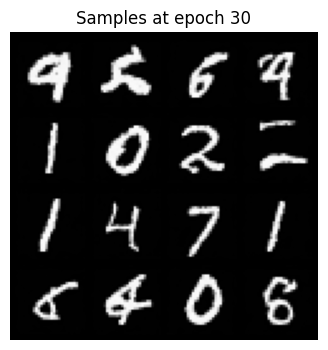

Total Epochs:  31%|███       | 31/100 [24:06<1:02:49, 54.63s/it]

Epoch 31 done. Avg Loss: 0.0409


Total Epochs:  32%|███▏      | 32/100 [25:00<1:01:59, 54.69s/it]

Epoch 32 done. Avg Loss: 0.0408


Total Epochs:  33%|███▎      | 33/100 [25:52<1:00:05, 53.81s/it]

Epoch 33 done. Avg Loss: 0.0407


Total Epochs:  34%|███▍      | 34/100 [26:44<58:28, 53.16s/it]  

Epoch 34 done. Avg Loss: 0.0404


Total Epochs:  35%|███▌      | 35/100 [27:35<57:06, 52.72s/it]

Epoch 35 done. Avg Loss: 0.0403


Total Epochs:  36%|███▌      | 36/100 [28:27<55:53, 52.40s/it]

Epoch 36 done. Avg Loss: 0.0401


Total Epochs:  37%|███▋      | 37/100 [29:19<54:47, 52.19s/it]

Epoch 37 done. Avg Loss: 0.0402


Total Epochs:  38%|███▊      | 38/100 [30:12<54:11, 52.45s/it]

Epoch 38 done. Avg Loss: 0.0397


Total Epochs:  39%|███▉      | 39/100 [31:06<53:58, 53.09s/it]

Epoch 39 done. Avg Loss: 0.0403


Epoch 40 done. Avg Loss: 0.0402


Sampling: 100%|██████████| 400/400 [00:02<00:00, 176.43it/s]


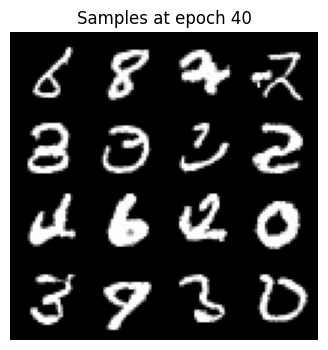

Total Epochs:  41%|████      | 41/100 [32:55<52:28, 53.36s/it]

Epoch 41 done. Avg Loss: 0.0398


Total Epochs:  42%|████▏     | 42/100 [33:46<51:00, 52.76s/it]

Epoch 42 done. Avg Loss: 0.0394


Total Epochs:  43%|████▎     | 43/100 [34:38<49:47, 52.41s/it]

Epoch 43 done. Avg Loss: 0.0398


Total Epochs:  44%|████▍     | 44/100 [35:33<49:40, 53.22s/it]

Epoch 44 done. Avg Loss: 0.0397


Total Epochs:  45%|████▌     | 45/100 [36:28<49:17, 53.77s/it]

Epoch 45 done. Avg Loss: 0.0393


Total Epochs:  46%|████▌     | 46/100 [37:20<47:55, 53.26s/it]

Epoch 46 done. Avg Loss: 0.0395


Total Epochs:  47%|████▋     | 47/100 [38:14<47:17, 53.53s/it]

Epoch 47 done. Avg Loss: 0.0392


Total Epochs:  48%|████▊     | 48/100 [39:10<46:57, 54.18s/it]

Epoch 48 done. Avg Loss: 0.0395


Total Epochs:  49%|████▉     | 49/100 [40:05<46:22, 54.56s/it]

Epoch 49 done. Avg Loss: 0.0392


Epoch 50 done. Avg Loss: 0.0390


Sampling: 100%|██████████| 400/400 [00:02<00:00, 166.31it/s]


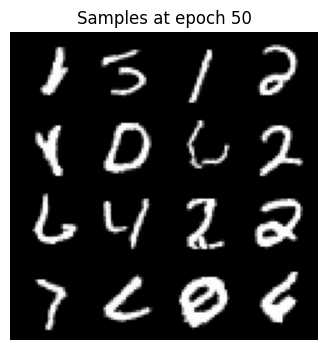

Total Epochs:  51%|█████     | 51/100 [41:59<45:24, 55.59s/it]

Epoch 51 done. Avg Loss: 0.0391


Total Epochs:  52%|█████▏    | 52/100 [42:54<44:26, 55.56s/it]

Epoch 52 done. Avg Loss: 0.0391


Total Epochs:  53%|█████▎    | 53/100 [43:50<43:28, 55.49s/it]

Epoch 53 done. Avg Loss: 0.0391


Total Epochs:  54%|█████▍    | 54/100 [44:45<42:31, 55.48s/it]

Epoch 54 done. Avg Loss: 0.0388


Total Epochs:  55%|█████▌    | 55/100 [45:40<41:22, 55.16s/it]

Epoch 55 done. Avg Loss: 0.0387


Total Epochs:  56%|█████▌    | 56/100 [46:35<40:34, 55.33s/it]

Epoch 56 done. Avg Loss: 0.0387


Total Epochs:  57%|█████▋    | 57/100 [47:31<39:42, 55.41s/it]

Epoch 57 done. Avg Loss: 0.0386


Total Epochs:  58%|█████▊    | 58/100 [48:27<38:49, 55.47s/it]

Epoch 58 done. Avg Loss: 0.0386


Total Epochs:  59%|█████▉    | 59/100 [49:22<37:57, 55.56s/it]

Epoch 59 done. Avg Loss: 0.0390


Epoch 60 done. Avg Loss: 0.0386


Sampling: 100%|██████████| 400/400 [00:02<00:00, 193.81it/s]


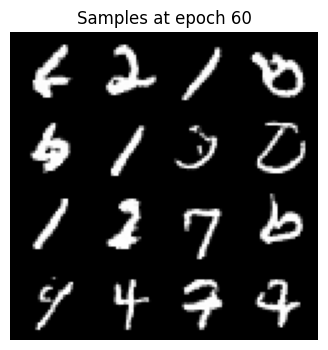

Total Epochs:  61%|██████    | 61/100 [51:16<36:25, 56.03s/it]

Epoch 61 done. Avg Loss: 0.0389


Total Epochs:  62%|██████▏   | 62/100 [52:11<35:24, 55.90s/it]

Epoch 62 done. Avg Loss: 0.0387


Total Epochs:  63%|██████▎   | 63/100 [53:06<34:14, 55.53s/it]

Epoch 63 done. Avg Loss: 0.0386


Total Epochs:  64%|██████▍   | 64/100 [54:01<33:14, 55.41s/it]

Epoch 64 done. Avg Loss: 0.0384


Total Epochs:  65%|██████▌   | 65/100 [54:57<32:21, 55.48s/it]

Epoch 65 done. Avg Loss: 0.0384


Total Epochs:  66%|██████▌   | 66/100 [55:54<31:43, 55.98s/it]

Epoch 66 done. Avg Loss: 0.0384


Total Epochs:  67%|██████▋   | 67/100 [56:51<30:57, 56.30s/it]

Epoch 67 done. Avg Loss: 0.0381


Total Epochs:  68%|██████▊   | 68/100 [57:48<30:09, 56.55s/it]

Epoch 68 done. Avg Loss: 0.0385


Total Epochs:  69%|██████▉   | 69/100 [58:44<29:06, 56.33s/it]

Epoch 69 done. Avg Loss: 0.0383


Epoch 70 done. Avg Loss: 0.0382


Sampling: 100%|██████████| 400/400 [00:02<00:00, 192.28it/s]


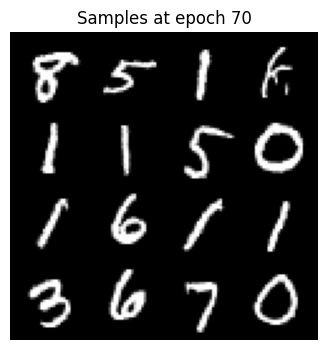

Total Epochs:  71%|███████   | 71/100 [1:00:32<26:34, 54.97s/it]

Epoch 71 done. Avg Loss: 0.0382


Total Epochs:  72%|███████▏  | 72/100 [1:01:24<25:12, 54.03s/it]

Epoch 72 done. Avg Loss: 0.0380


Total Epochs:  73%|███████▎  | 73/100 [1:02:17<24:09, 53.70s/it]

Epoch 73 done. Avg Loss: 0.0381


Total Epochs:  74%|███████▍  | 74/100 [1:03:10<23:13, 53.58s/it]

Epoch 74 done. Avg Loss: 0.0381


Total Epochs:  75%|███████▌  | 75/100 [1:04:03<22:16, 53.47s/it]

Epoch 75 done. Avg Loss: 0.0381


Total Epochs:  76%|███████▌  | 76/100 [1:04:57<21:25, 53.54s/it]

Epoch 76 done. Avg Loss: 0.0382


Total Epochs:  77%|███████▋  | 77/100 [1:05:51<20:34, 53.70s/it]

Epoch 77 done. Avg Loss: 0.0379


Total Epochs:  78%|███████▊  | 78/100 [1:06:45<19:39, 53.63s/it]

Epoch 78 done. Avg Loss: 0.0381


Total Epochs:  79%|███████▉  | 79/100 [1:07:39<18:51, 53.87s/it]

Epoch 79 done. Avg Loss: 0.0379


Epoch 80 done. Avg Loss: 0.0379


Sampling: 100%|██████████| 400/400 [00:02<00:00, 188.11it/s]


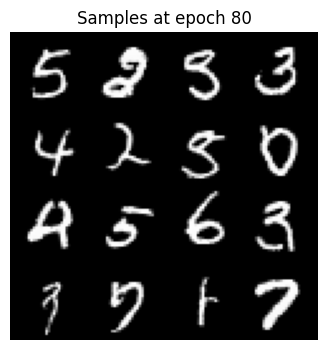

Total Epochs:  81%|████████  | 81/100 [1:09:28<17:06, 54.01s/it]

Epoch 81 done. Avg Loss: 0.0379


Total Epochs:  82%|████████▏ | 82/100 [1:10:21<16:09, 53.85s/it]

Epoch 82 done. Avg Loss: 0.0379


Total Epochs:  83%|████████▎ | 83/100 [1:11:15<15:14, 53.79s/it]

Epoch 83 done. Avg Loss: 0.0380


Total Epochs:  84%|████████▍ | 84/100 [1:12:08<14:18, 53.68s/it]

Epoch 84 done. Avg Loss: 0.0382


Total Epochs:  85%|████████▌ | 85/100 [1:13:02<13:25, 53.69s/it]

Epoch 85 done. Avg Loss: 0.0378


Total Epochs:  86%|████████▌ | 86/100 [1:13:56<12:32, 53.73s/it]

Epoch 86 done. Avg Loss: 0.0380


Total Epochs:  87%|████████▋ | 87/100 [1:14:49<11:37, 53.63s/it]

Epoch 87 done. Avg Loss: 0.0378


Total Epochs:  88%|████████▊ | 88/100 [1:15:43<10:43, 53.63s/it]

Epoch 88 done. Avg Loss: 0.0376


Total Epochs:  89%|████████▉ | 89/100 [1:16:37<09:50, 53.67s/it]

Epoch 89 done. Avg Loss: 0.0378


Epoch 90 done. Avg Loss: 0.0380


Sampling: 100%|██████████| 400/400 [00:02<00:00, 188.17it/s]


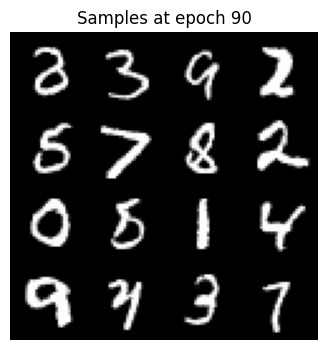

Total Epochs:  91%|█████████ | 91/100 [1:18:27<08:08, 54.25s/it]

Epoch 91 done. Avg Loss: 0.0377


Total Epochs:  92%|█████████▏| 92/100 [1:19:21<07:13, 54.21s/it]

Epoch 92 done. Avg Loss: 0.0376


Total Epochs:  93%|█████████▎| 93/100 [1:20:14<06:18, 54.07s/it]

Epoch 93 done. Avg Loss: 0.0376


Total Epochs:  94%|█████████▍| 94/100 [1:21:08<05:23, 53.98s/it]

Epoch 94 done. Avg Loss: 0.0376


Total Epochs:  95%|█████████▌| 95/100 [1:22:02<04:29, 53.89s/it]

Epoch 95 done. Avg Loss: 0.0379


Total Epochs:  96%|█████████▌| 96/100 [1:22:56<03:35, 53.87s/it]

Epoch 96 done. Avg Loss: 0.0375


Total Epochs:  97%|█████████▋| 97/100 [1:23:47<02:39, 53.12s/it]

Epoch 97 done. Avg Loss: 0.0377


Total Epochs:  98%|█████████▊| 98/100 [1:24:38<01:45, 52.59s/it]

Epoch 98 done. Avg Loss: 0.0377


Total Epochs:  99%|█████████▉| 99/100 [1:25:30<00:52, 52.19s/it]

Epoch 99 done. Avg Loss: 0.0374


Epoch 100 done. Avg Loss: 0.0377


Sampling: 100%|██████████| 400/400 [00:02<00:00, 165.23it/s]


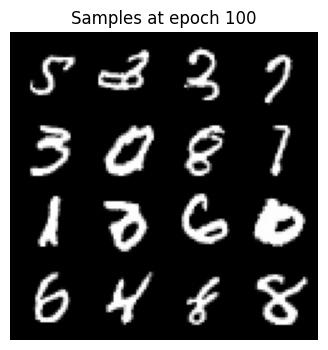

Total Epochs: 100%|██████████| 100/100 [1:26:24<00:00, 51.84s/it]

Training complete!


In [3]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=256,  
    epochs=100,      
    timesteps=400,   
    model_base_dim=32, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=2, 
    num_res_blocks_decoder=2, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

UNet model has 438,049 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:51<1:24:30, 51.22s/it]

Epoch 1 done. Avg Loss: 0.3134


Total Epochs:   2%|▏         | 2/100 [01:42<1:23:45, 51.28s/it]

Epoch 2 done. Avg Loss: 0.0981


Total Epochs:   3%|▎         | 3/100 [02:33<1:22:58, 51.33s/it]

Epoch 3 done. Avg Loss: 0.0750


Total Epochs:   4%|▍         | 4/100 [03:25<1:22:06, 51.32s/it]

Epoch 4 done. Avg Loss: 0.0662


Total Epochs:   5%|▌         | 5/100 [04:16<1:21:19, 51.36s/it]

Epoch 5 done. Avg Loss: 0.0603


Total Epochs:   6%|▌         | 6/100 [05:08<1:20:29, 51.38s/it]

Epoch 6 done. Avg Loss: 0.0562


Total Epochs:   7%|▋         | 7/100 [05:59<1:19:33, 51.33s/it]

Epoch 7 done. Avg Loss: 0.0532


Total Epochs:   8%|▊         | 8/100 [06:50<1:18:45, 51.36s/it]

Epoch 8 done. Avg Loss: 0.0514


Total Epochs:   9%|▉         | 9/100 [07:42<1:17:55, 51.38s/it]

Epoch 9 done. Avg Loss: 0.0503


Epoch 10 done. Avg Loss: 0.0492


Sampling: 100%|██████████| 800/800 [00:04<00:00, 176.83it/s]


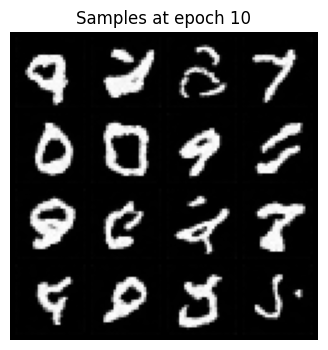

Total Epochs:  11%|█         | 11/100 [09:29<1:17:37, 52.34s/it]

Epoch 11 done. Avg Loss: 0.0472


Total Epochs:  12%|█▏        | 12/100 [10:20<1:16:18, 52.03s/it]

Epoch 12 done. Avg Loss: 0.0472


Total Epochs:  13%|█▎        | 13/100 [11:12<1:15:10, 51.85s/it]

Epoch 13 done. Avg Loss: 0.0461


Total Epochs:  14%|█▍        | 14/100 [12:03<1:14:07, 51.72s/it]

Epoch 14 done. Avg Loss: 0.0450


Total Epochs:  15%|█▌        | 15/100 [12:54<1:13:05, 51.60s/it]

Epoch 15 done. Avg Loss: 0.0450


Total Epochs:  16%|█▌        | 16/100 [13:46<1:12:09, 51.54s/it]

Epoch 16 done. Avg Loss: 0.0448


Total Epochs:  17%|█▋        | 17/100 [14:37<1:11:12, 51.47s/it]

Epoch 17 done. Avg Loss: 0.0440


Total Epochs:  18%|█▊        | 18/100 [15:28<1:10:15, 51.40s/it]

Epoch 18 done. Avg Loss: 0.0438


Total Epochs:  19%|█▉        | 19/100 [16:20<1:09:23, 51.40s/it]

Epoch 19 done. Avg Loss: 0.0436


Epoch 20 done. Avg Loss: 0.0433


Sampling: 100%|██████████| 800/800 [00:04<00:00, 179.75it/s]


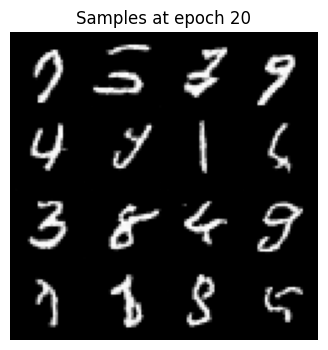

Total Epochs:  21%|██        | 21/100 [18:07<1:08:55, 52.35s/it]

Epoch 21 done. Avg Loss: 0.0430


Total Epochs:  22%|██▏       | 22/100 [18:58<1:07:40, 52.06s/it]

Epoch 22 done. Avg Loss: 0.0428


Total Epochs:  23%|██▎       | 23/100 [19:50<1:06:33, 51.86s/it]

Epoch 23 done. Avg Loss: 0.0425


Total Epochs:  24%|██▍       | 24/100 [20:41<1:05:29, 51.71s/it]

Epoch 24 done. Avg Loss: 0.0423


Total Epochs:  25%|██▌       | 25/100 [21:33<1:04:30, 51.61s/it]

Epoch 25 done. Avg Loss: 0.0421


Total Epochs:  26%|██▌       | 26/100 [22:24<1:03:31, 51.51s/it]

Epoch 26 done. Avg Loss: 0.0420


Total Epochs:  27%|██▋       | 27/100 [23:15<1:02:38, 51.48s/it]

Epoch 27 done. Avg Loss: 0.0419


Total Epochs:  28%|██▊       | 28/100 [24:07<1:01:44, 51.45s/it]

Epoch 28 done. Avg Loss: 0.0418


Total Epochs:  29%|██▉       | 29/100 [24:38<53:44, 45.42s/it]  

Epoch 29 done. Avg Loss: 0.0416


Epoch 30 done. Avg Loss: 0.0414


Sampling: 100%|██████████| 800/800 [00:03<00:00, 237.13it/s]


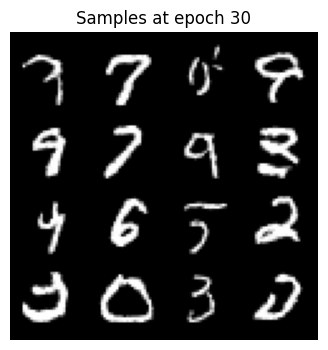

Total Epochs:  31%|███       | 31/100 [25:35<42:09, 36.66s/it]

Epoch 31 done. Avg Loss: 0.0412


Total Epochs:  32%|███▏      | 32/100 [26:02<38:11, 33.69s/it]

Epoch 32 done. Avg Loss: 0.0409


Total Epochs:  33%|███▎      | 33/100 [26:29<35:19, 31.63s/it]

Epoch 33 done. Avg Loss: 0.0410


Total Epochs:  34%|███▍      | 34/100 [26:55<33:10, 30.16s/it]

Epoch 34 done. Avg Loss: 0.0406


Total Epochs:  35%|███▌      | 35/100 [27:22<31:37, 29.19s/it]

Epoch 35 done. Avg Loss: 0.0412


Total Epochs:  36%|███▌      | 36/100 [27:49<30:24, 28.51s/it]

Epoch 36 done. Avg Loss: 0.0404


Total Epochs:  37%|███▋      | 37/100 [28:16<29:22, 27.98s/it]

Epoch 37 done. Avg Loss: 0.0407


Total Epochs:  38%|███▊      | 38/100 [28:43<28:32, 27.62s/it]

Epoch 38 done. Avg Loss: 0.0403


Total Epochs:  39%|███▉      | 39/100 [29:09<27:44, 27.29s/it]

Epoch 39 done. Avg Loss: 0.0404


Epoch 40 done. Avg Loss: 0.0398


Sampling: 100%|██████████| 800/800 [00:03<00:00, 237.51it/s]


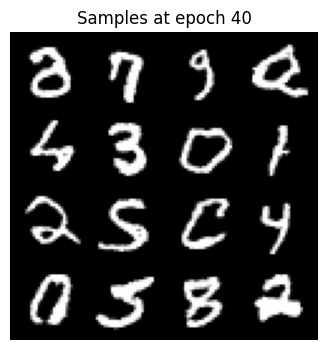

Total Epochs:  41%|████      | 41/100 [30:06<27:15, 27.71s/it]

Epoch 41 done. Avg Loss: 0.0404


Total Epochs:  42%|████▏     | 42/100 [30:33<26:31, 27.44s/it]

Epoch 42 done. Avg Loss: 0.0399


Total Epochs:  43%|████▎     | 43/100 [31:00<25:55, 27.29s/it]

Epoch 43 done. Avg Loss: 0.0402


Total Epochs:  44%|████▍     | 44/100 [31:27<25:17, 27.10s/it]

Epoch 44 done. Avg Loss: 0.0399


Total Epochs:  45%|████▌     | 45/100 [31:53<24:45, 27.00s/it]

Epoch 45 done. Avg Loss: 0.0398


Total Epochs:  46%|████▌     | 46/100 [32:20<24:13, 26.92s/it]

Epoch 46 done. Avg Loss: 0.0396


Total Epochs:  47%|████▋     | 47/100 [32:47<23:43, 26.87s/it]

Epoch 47 done. Avg Loss: 0.0400


Total Epochs:  48%|████▊     | 48/100 [33:14<23:16, 26.85s/it]

Epoch 48 done. Avg Loss: 0.0398


Total Epochs:  49%|████▉     | 49/100 [33:40<22:48, 26.83s/it]

Epoch 49 done. Avg Loss: 0.0395


Epoch 50 done. Avg Loss: 0.0397


Sampling: 100%|██████████| 800/800 [00:03<00:00, 231.86it/s]


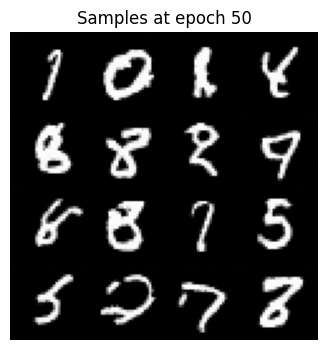

Total Epochs:  51%|█████     | 51/100 [34:37<22:29, 27.54s/it]

Epoch 51 done. Avg Loss: 0.0395


Total Epochs:  52%|█████▏    | 52/100 [35:04<21:51, 27.32s/it]

Epoch 52 done. Avg Loss: 0.0393


Total Epochs:  53%|█████▎    | 53/100 [35:31<21:17, 27.19s/it]

Epoch 53 done. Avg Loss: 0.0393


Total Epochs:  54%|█████▍    | 54/100 [35:58<20:45, 27.08s/it]

Epoch 54 done. Avg Loss: 0.0393


Total Epochs:  55%|█████▌    | 55/100 [36:25<20:16, 27.02s/it]

Epoch 55 done. Avg Loss: 0.0389


Total Epochs:  56%|█████▌    | 56/100 [36:52<19:47, 26.99s/it]

Epoch 56 done. Avg Loss: 0.0393


Total Epochs:  57%|█████▋    | 57/100 [37:18<19:16, 26.90s/it]

Epoch 57 done. Avg Loss: 0.0393


Total Epochs:  58%|█████▊    | 58/100 [37:45<18:49, 26.89s/it]

Epoch 58 done. Avg Loss: 0.0393


Total Epochs:  59%|█████▉    | 59/100 [38:12<18:19, 26.82s/it]

Epoch 59 done. Avg Loss: 0.0390


Epoch 60 done. Avg Loss: 0.0389


Sampling: 100%|██████████| 800/800 [00:03<00:00, 236.55it/s]


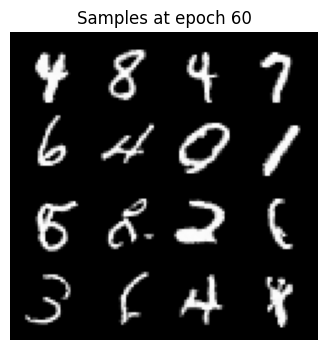

Total Epochs:  61%|██████    | 61/100 [39:09<17:53, 27.52s/it]

Epoch 61 done. Avg Loss: 0.0393


Total Epochs:  62%|██████▏   | 62/100 [39:36<17:16, 27.29s/it]

Epoch 62 done. Avg Loss: 0.0393


Total Epochs:  63%|██████▎   | 63/100 [40:02<16:43, 27.12s/it]

Epoch 63 done. Avg Loss: 0.0388


Total Epochs:  64%|██████▍   | 64/100 [40:29<16:14, 27.08s/it]

Epoch 64 done. Avg Loss: 0.0387


Total Epochs:  65%|██████▌   | 65/100 [40:56<15:44, 26.97s/it]

Epoch 65 done. Avg Loss: 0.0388


Total Epochs:  66%|██████▌   | 66/100 [41:23<15:16, 26.95s/it]

Epoch 66 done. Avg Loss: 0.0389


Total Epochs:  67%|██████▋   | 67/100 [41:50<14:48, 26.94s/it]

Epoch 67 done. Avg Loss: 0.0388


Total Epochs:  68%|██████▊   | 68/100 [42:17<14:19, 26.87s/it]

Epoch 68 done. Avg Loss: 0.0389


Total Epochs:  69%|██████▉   | 69/100 [42:43<13:52, 26.86s/it]

Epoch 69 done. Avg Loss: 0.0391


Epoch 70 done. Avg Loss: 0.0386


Sampling: 100%|██████████| 800/800 [00:03<00:00, 236.67it/s]


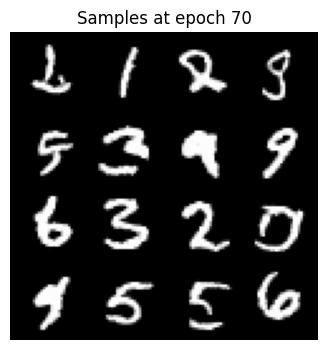

Total Epochs:  71%|███████   | 71/100 [43:40<13:16, 27.47s/it]

Epoch 71 done. Avg Loss: 0.0390


Total Epochs:  72%|███████▏  | 72/100 [44:07<12:43, 27.28s/it]

Epoch 72 done. Avg Loss: 0.0384


Total Epochs:  73%|███████▎  | 73/100 [44:34<12:13, 27.17s/it]

Epoch 73 done. Avg Loss: 0.0387


Total Epochs:  74%|███████▍  | 74/100 [45:01<11:42, 27.02s/it]

Epoch 74 done. Avg Loss: 0.0388


Total Epochs:  75%|███████▌  | 75/100 [45:27<11:13, 26.95s/it]

Epoch 75 done. Avg Loss: 0.0384


Total Epochs:  76%|███████▌  | 76/100 [45:54<10:46, 26.93s/it]

Epoch 76 done. Avg Loss: 0.0385


Total Epochs:  77%|███████▋  | 77/100 [46:21<10:17, 26.86s/it]

Epoch 77 done. Avg Loss: 0.0384


Total Epochs:  78%|███████▊  | 78/100 [46:48<09:48, 26.77s/it]

Epoch 78 done. Avg Loss: 0.0384


Total Epochs:  79%|███████▉  | 79/100 [47:14<09:22, 26.80s/it]

Epoch 79 done. Avg Loss: 0.0385


Epoch 80 done. Avg Loss: 0.0384


Sampling: 100%|██████████| 800/800 [00:03<00:00, 235.78it/s]


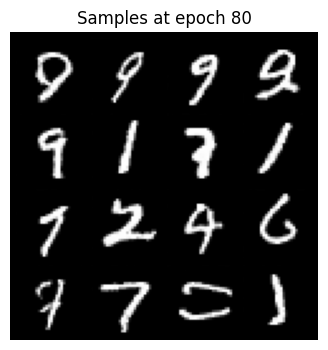

Total Epochs:  81%|████████  | 81/100 [48:11<08:42, 27.51s/it]

Epoch 81 done. Avg Loss: 0.0385


Total Epochs:  82%|████████▏ | 82/100 [48:38<08:11, 27.30s/it]

Epoch 82 done. Avg Loss: 0.0385


Total Epochs:  83%|████████▎ | 83/100 [49:05<07:40, 27.07s/it]

Epoch 83 done. Avg Loss: 0.0382


Total Epochs:  84%|████████▍ | 84/100 [49:32<07:11, 26.98s/it]

Epoch 84 done. Avg Loss: 0.0382


Total Epochs:  85%|████████▌ | 85/100 [49:58<06:43, 26.91s/it]

Epoch 85 done. Avg Loss: 0.0380


Total Epochs:  86%|████████▌ | 86/100 [50:25<06:16, 26.87s/it]

Epoch 86 done. Avg Loss: 0.0381


Total Epochs:  87%|████████▋ | 87/100 [50:52<05:48, 26.82s/it]

Epoch 87 done. Avg Loss: 0.0384


Total Epochs:  88%|████████▊ | 88/100 [51:19<05:21, 26.81s/it]

Epoch 88 done. Avg Loss: 0.0381


Total Epochs:  89%|████████▉ | 89/100 [51:46<04:55, 26.86s/it]

Epoch 89 done. Avg Loss: 0.0383


Epoch 90 done. Avg Loss: 0.0381


Sampling: 100%|██████████| 800/800 [00:03<00:00, 239.13it/s]


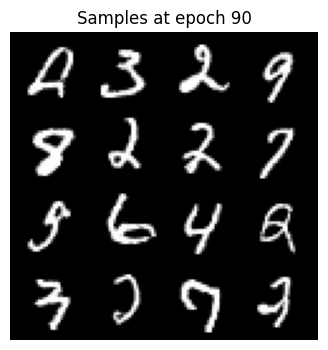

Total Epochs:  91%|█████████ | 91/100 [52:42<04:07, 27.49s/it]

Epoch 91 done. Avg Loss: 0.0381


Total Epochs:  92%|█████████▏| 92/100 [53:09<03:38, 27.27s/it]

Epoch 92 done. Avg Loss: 0.0380


Total Epochs:  93%|█████████▎| 93/100 [53:36<03:09, 27.11s/it]

Epoch 93 done. Avg Loss: 0.0383


Total Epochs:  94%|█████████▍| 94/100 [54:02<02:41, 26.94s/it]

Epoch 94 done. Avg Loss: 0.0380


Total Epochs:  95%|█████████▌| 95/100 [54:29<02:14, 26.88s/it]

Epoch 95 done. Avg Loss: 0.0380


Total Epochs:  96%|█████████▌| 96/100 [54:56<01:47, 26.80s/it]

Epoch 96 done. Avg Loss: 0.0383


Total Epochs:  97%|█████████▋| 97/100 [55:22<01:20, 26.79s/it]

Epoch 97 done. Avg Loss: 0.0377


Total Epochs:  98%|█████████▊| 98/100 [55:49<00:53, 26.77s/it]

Epoch 98 done. Avg Loss: 0.0379


Total Epochs:  99%|█████████▉| 99/100 [56:16<00:26, 26.79s/it]

Epoch 99 done. Avg Loss: 0.0379


Epoch 100 done. Avg Loss: 0.0378


Sampling: 100%|██████████| 800/800 [00:03<00:00, 233.53it/s]


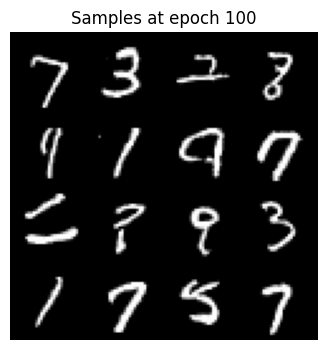

Total Epochs: 100%|██████████| 100/100 [56:46<00:00, 34.07s/it]

Training complete!


In [4]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=256,  
    epochs=100,      
    timesteps=800,   
    model_base_dim=32, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=2, 
    num_res_blocks_decoder=2, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

The generated images are sharper than those of VAEs! But diffusion takes significantly more time than VAEs since it has to make way more forward passes, but more forward passes, the better the generated image quality is.